In [63]:
import numpy as np
import matplotlib.pyplot as plt

import jax
from functools import partial
import jax.numpy as jnp

plt.rcParams['figure.figsize'] = [12, 8] # PDF 

import time
from tqdm import tqdm

from Dynamics import logistic_map, henon_map, lorentz_map
from Kernels import ext_kernel
from Losses import rho_comp

from Optimizer import main_flow, main_sos
from DataManager import get_curr_data, sample_points
from utils import get_predict_func, gen_traj, predict_series, get_pred_funcs, set_seed, hausdorff_distance, save_res, load_res
from notebook_utils import do_test, get_thetas, print_stats, get_latex_test, get_latex_train, get_latex_rho

jax.config.update("jax_enable_x64", True)

import tikzplotlib


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:

def get_data(dyn_type):
    if dyn_type == "Henon":
        a = 1.4
        b = 0.3

        x = -0.75
        y = -0.3
        x_vec_0 = [x, y]

        traj_train = jnp.array(gen_traj(henon_map(a, b), x_vec_0, 1000))

        X_train = traj_train[:-1]
        Y_train = traj_train[1:]

        x_vec_0_test = jnp.array([0.5, 0.])

        traj_test = jnp.array(gen_traj(henon_map(a, b), x_vec_0_test, 1000))
        
    elif dyn_type == "Logistic":
        r = 4
        x = 0.1

        x_vec_0 = jnp.array([x])

        traj_train = jnp.array(gen_traj(logistic_map(r), x_vec_0, 200))

        X_train = traj_train[:-1]
        Y_train = traj_train[1:]
        
        x_vec_0_test = jnp.array([0.3])

        N_test = 200

        traj_test = jnp.array(gen_traj(logistic_map(r), x_vec_0_test, N_test))

    else:
        x_vec_0 = [0.5, 1.5, 2.5]

        traj_train = jnp.array(gen_traj(lorentz_map(), x_vec_0, 1000))

        X_train = traj_train[:-1]
        Y_train = traj_train[1:]

        x_vec_0_test = [0.7, 1.1, 2.]

        traj_test = jnp.array(gen_traj(lorentz_map(), x_vec_0_test, 1000))

        
    return X_train, Y_train, traj_train, traj_test, x_vec_0, x_vec_0_test
    
def vis_plot(traj, c):
    if len(traj.shape)== 1 or traj.shape[1] == 1:
        plt.plot(traj, c=c)
        plt.xlabel("Iterations")
        plt.ylabel("$x_1$")
    elif traj.shape[1] == 2:
        plt.scatter(traj[:, 0], traj[:, 1], c=c)
        plt.xlabel("$x_1$")
        plt.ylabel("$x_2$")
    else:
        ax = plt.figure().add_subplot(projection='3d')
        ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], c=c, linewidth=3)

        
        # Customize axis labels with font properties
        label_font = {'fontsize': 20}
        
        ax.set_xlabel('$x_1$', fontdict=label_font)
        ax.set_ylabel('$x_2$', fontdict=label_font)
        ax.set_zlabel('$x_3$', fontdict=label_font)
        
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.tick_params(axis='both', which='minor', labelsize=14)

# Visualizations 

In [65]:
idx = 0

dyn_type = "Lorentz"
res = load_res(dyn_type)

X_train, Y_train, traj_train, traj_test, x_vec_0, x_vec_0_test = get_data(dyn_type)

In [66]:
print("Test")
get_latex_test(res)
print()
print("Train")
get_latex_train(res)
print()
print("Rho")
get_latex_rho(res)

Test
MSE & $1.10 \ [0.93, 1.32] \times 10^{-1}$ & $2.30 \ [2.14, 3.00] \times 10^{-1}$ \\ HD & $6.32 \ [5.52, 6.44]$ & $8.57 \ [6.72, 12.75]$ \\ Deviation (0.1) & $1.00$ & $1.00$ \\ Deviation (0.25) & $3.32 \ [3.14, 3.46] \times 10^{2}$ & $6.15 \ [4.42, 16.57] \times 10^{1}$ \\ 

Train
MSE & $1.17 \ [1.07, 1.21] \times 10^{-13}$ & $4.29 \ [3.66, 4.59] \times 10^{-14}$ \\ HD & $7.38 \ [3.17, 9.25]$ & $9.46 \ [7.96, 11.15]$ \\ Deviation (0.1) & $5.57 \ [3.44, 7.41] \times 10^{2}$ & $2.37 \ [0.64, 3.16] \times 10^{2}$ \\ Deviation (0.25) & $3.71 \ [0.81, 5.79] \times 10^{2}$ & $2.74 \ [1.32, 3.27] \times 10^{2}$ \\ 

Rho
Rho & $2.98 \ [2.07, 4.41] \times 10^{-2}$ & $6.59 \ [4.73, 10.63] \times 10^{-2}$ \\ 


## Optimization Error

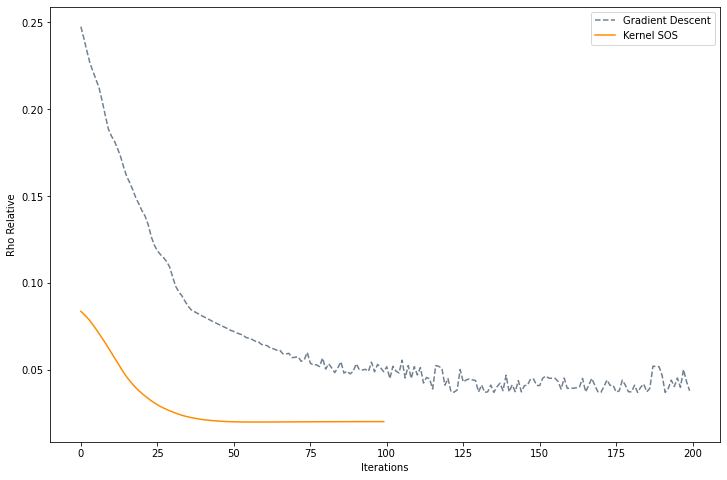

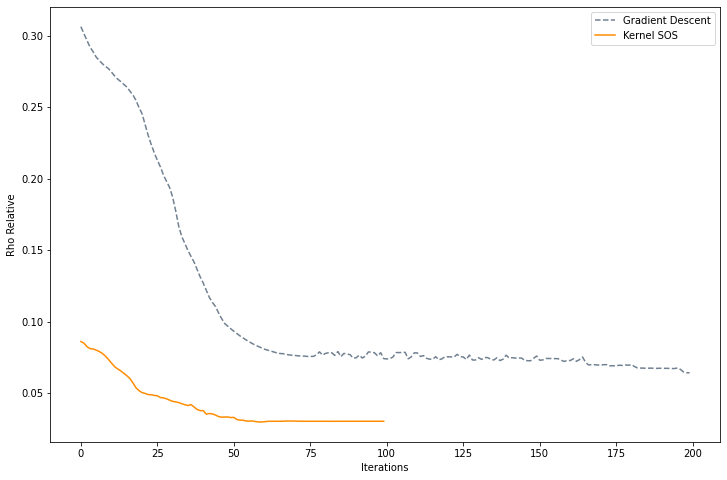

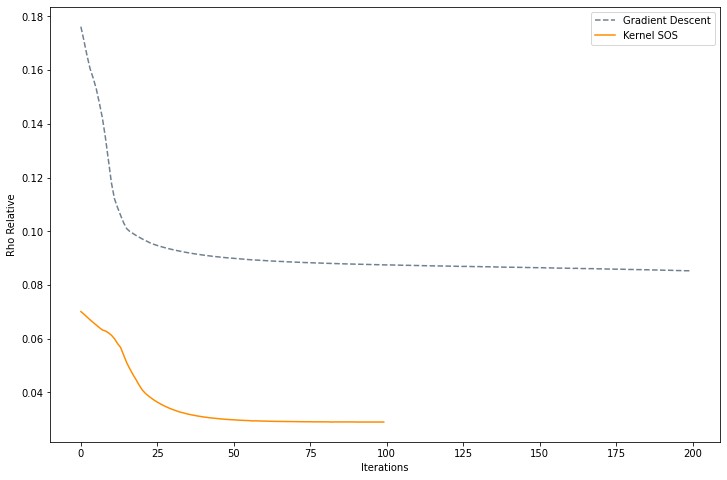

In [67]:


for dim_idx in range(len(res['thetas_flow'][0])):


    plt.plot(res["losses_flow"][idx, dim_idx, :], label="Gradient Descent", linestyle="--", c='slategrey')
    plt.plot(res["losses_sos"][idx, dim_idx, :], label="Kernel SOS", c="darkorange")

    plt.xlabel("Iterations")
    plt.ylabel("Rho Relative")

    plt.legend()
    
    tikzplotlib.save(f"Figures/{dyn_type}_rho_{dim_idx}_idx.tex")
    plt.show()

## Get auto-reg

In [68]:
pred_funcs_flow = get_pred_funcs(res['thetas_flow'][idx], ext_kernel, X_train, Y_train)
pred_funcs_sos = get_pred_funcs(res['thetas_sos'][idx], ext_kernel, X_train, Y_train)

traj_preds_flow = predict_series(pred_funcs_flow, jnp.array(x_vec_0_test), len(X_train))
traj_preds_sos = predict_series(pred_funcs_sos, jnp.array(x_vec_0_test), len(X_train))

100%|██████████| 1000/1000 [01:04<00:00, 15.49it/s]


In [69]:
pred_funcs_flow = get_pred_funcs(res['thetas_flow'][idx], ext_kernel, X_train, Y_train)
pred_funcs_sos = get_pred_funcs(res['thetas_sos'][idx], ext_kernel, X_train, Y_train)

traj_train_preds_flow = predict_series(pred_funcs_flow, jnp.array(x_vec_0), len(X_train))
traj_train_preds_sos = predict_series(pred_funcs_sos, jnp.array(x_vec_0), len(X_train))

100%|██████████| 1000/1000 [01:04<00:00, 15.50it/s]


## Test Distance

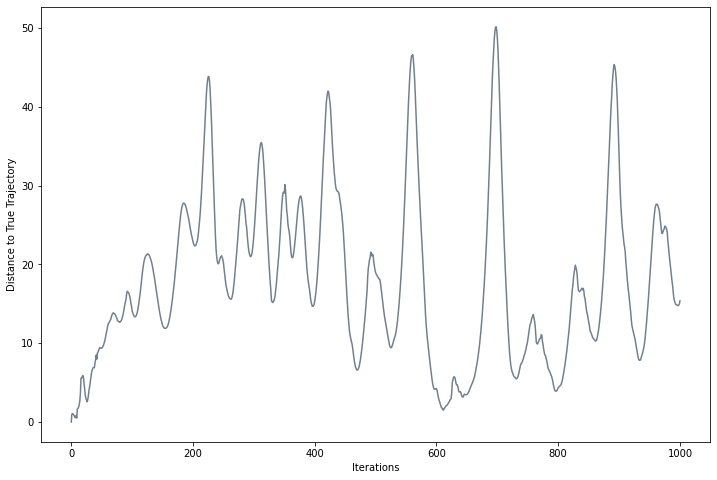

In [70]:

opt_type = "flow"

plt.plot(np.linalg.norm((traj_test - traj_preds_flow), axis=1), c='slategrey')

plt.xlabel("Iterations")
plt.ylabel("Distance to True Trajectory")

tikzplotlib.save(f"Figures/{dyn_type}_errTraj_{opt_type}.tex")

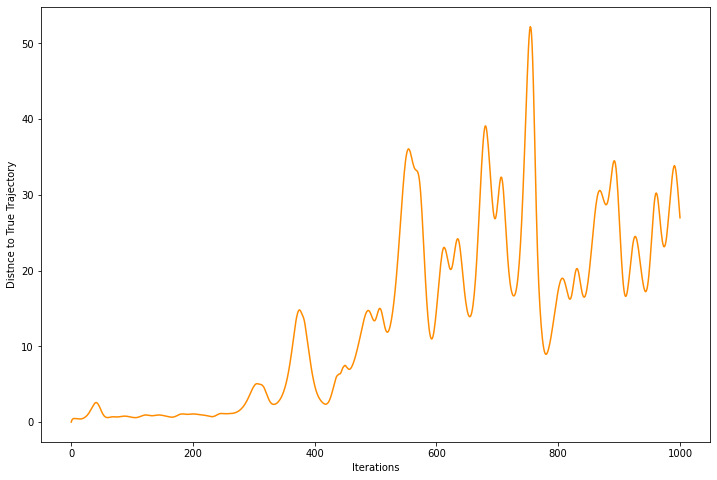

In [71]:

opt_type = "sos"

plt.plot(np.linalg.norm((traj_test - traj_preds_sos), axis=1), c="darkorange")

plt.xlabel("Iterations")
plt.ylabel("Distnce to True Trajectory")

tikzplotlib.save(f"Figures/{dyn_type}_errTraj_{opt_type}.tex")

## Training Distance

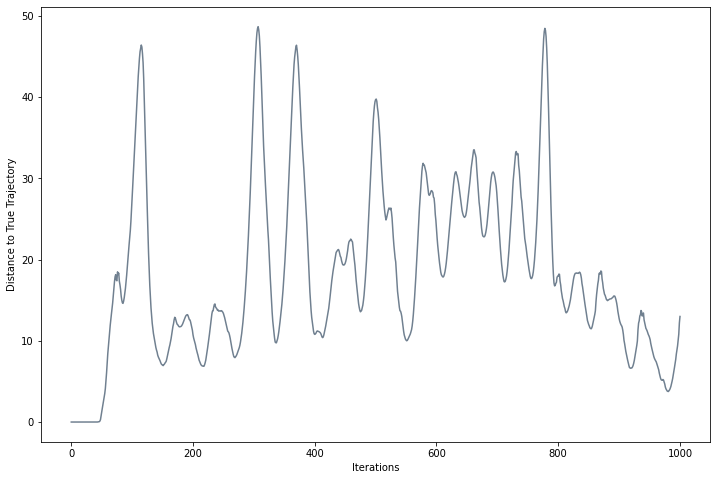

In [72]:

opt_type = "flow"

plt.plot(np.linalg.norm((traj_train - traj_train_preds_flow), axis=1), c='slategrey')

plt.xlabel("Iterations")
plt.ylabel("Distance to True Trajectory")

tikzplotlib.save(f"Figures/{dyn_type}_errTrajTrain_{opt_type}.tex")

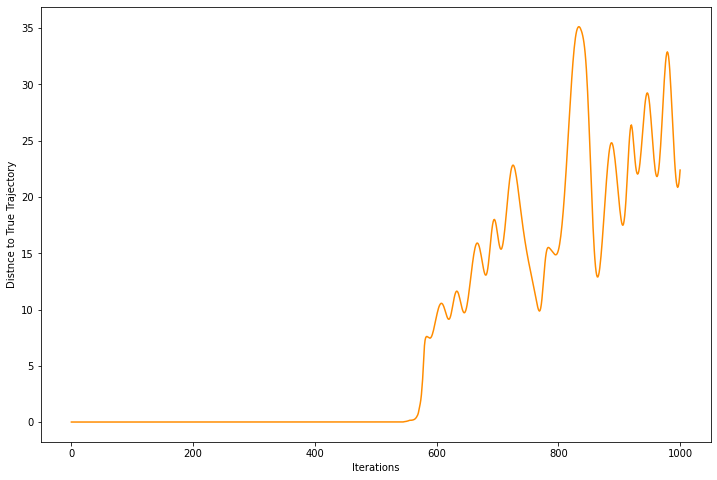

In [73]:

opt_type = "sos"

plt.plot(np.linalg.norm((traj_train - traj_train_preds_sos), axis=1), c="darkorange")

plt.xlabel("Iterations")
plt.ylabel("Distnce to True Trajectory")

tikzplotlib.save(f"Figures/{dyn_type}_errTrajTrain_{opt_type}.tex")

## Traj Test Vis

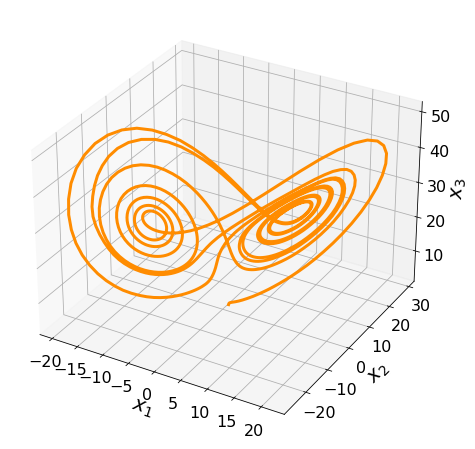

In [112]:

opt_type = "sos"

vis_plot(traj_preds_sos, c='darkorange')

if traj_train.shape[1] == 3:
    plt.savefig(f"Figures/{dyn_type}_Traj_{opt_type}.pdf", dpi=300, bbox_inches='tight', pad_inches=0.1)
else:
    tikzplotlib.save(f"Figures/{dyn_type}_Traj_{opt_type}.tex")
    
    
plt.show()

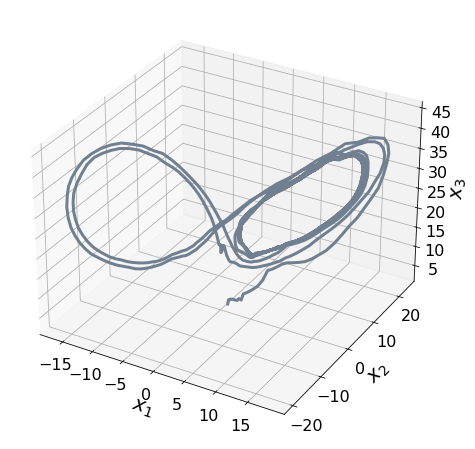

In [113]:


opt_type = "flow"

vis_plot(traj_preds_flow, c='slategrey')

if traj_train.shape[1] == 3:
    plt.savefig(f"Figures/{dyn_type}_Traj_{opt_type}.pdf", dpi=300, bbox_inches='tight', pad_inches=0.1)
else:
    tikzplotlib.save(f"Figures/{dyn_type}_Traj_{opt_type}.tex")
    
    
plt.show()

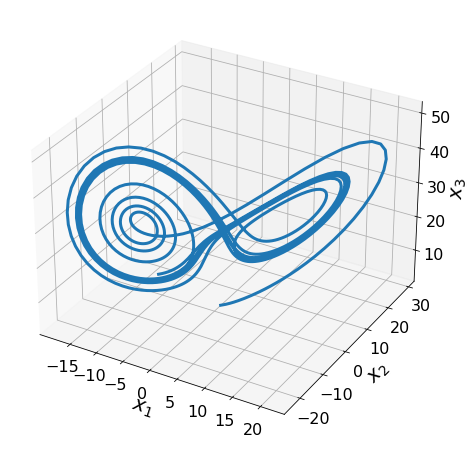

In [114]:


opt_type = "true"

vis_plot(traj_test, c='C0')

if traj_train.shape[1] == 3:
    plt.savefig(f"Figures/{dyn_type}_Traj_{opt_type}.pdf", dpi=300, bbox_inches='tight', pad_inches=0.1)
else:
    tikzplotlib.save(f"Figures/{dyn_type}_Traj_{opt_type}.tex")

plt.show()

# Traj Train Vis

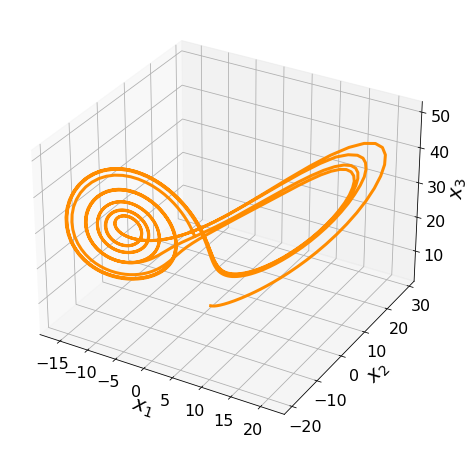

In [115]:
opt_type = "sos"

vis_plot(traj_train_preds_sos, c='darkorange')

if traj_train.shape[1] == 3:
    plt.savefig(f"Figures/{dyn_type}_TrajTrain_{opt_type}.pdf", dpi=300, bbox_inches='tight', pad_inches=0.1)
else:
    tikzplotlib.save(f"Figures/{dyn_type}_TrajTrain_{opt_type}.tex")

plt.show()

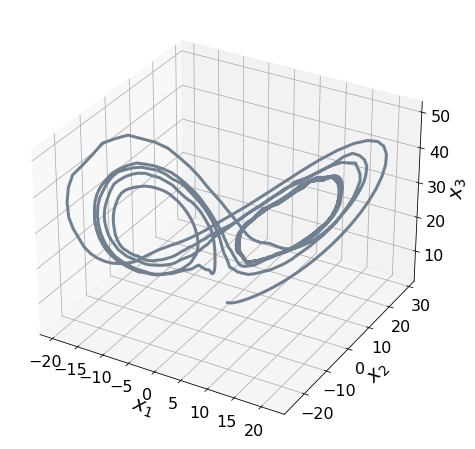

In [116]:


opt_type = "flow"

vis_plot(traj_train_preds_flow, c='slategrey')

if traj_train.shape[1] == 3:
    plt.savefig(f"Figures/{dyn_type}_TrajTrain_{opt_type}.pdf", dpi=300, bbox_inches='tight', pad_inches=0.1)
else:
    tikzplotlib.save(f"Figures/{dyn_type}_TrajTrain_{opt_type}.tex")
    
plt.show()

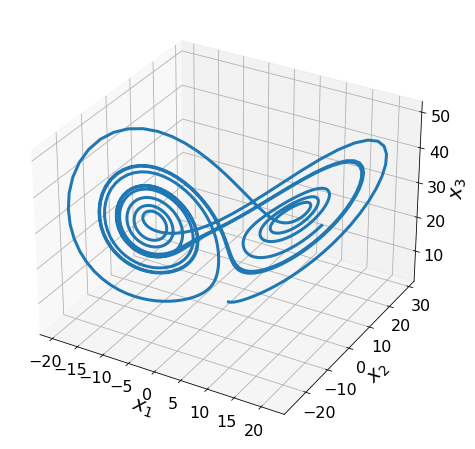

In [117]:


opt_type = "true"

vis_plot(traj_train, c='C0')


if traj_train.shape[1] == 3:
    plt.savefig(f"Figures/{dyn_type}_TrajTrain_{opt_type}.pdf", dpi=300, bbox_inches='tight', pad_inches=0.1)
else:
    tikzplotlib.save(f"Figures/{dyn_type}_TrajTrain_{opt_type}.tex")
    
plt.show()